In [ ]:
NAME = "Junyu Zhu"

In [ ]:
#I use generated fake data instead to show/test the project since notebook lacks some module

In [ ]:
import pandas as pd
import random
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from scipy.stats import spearmanr
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


In [ ]:
# Section 1: Getting data(Not used here)

In [ ]:
# Read posts data
posts_df = pd.read_csv('sample_posts.txt', sep='\t')
print("Posts Data:")
print(posts_df.head())

# Read survey data
survey_df = pd.read_csv('sample_survey.txt', sep='\t')
print("\nSurvey Data:")
print(survey_df.head())

In [ ]:
# Section 1: Data Generation

In [15]:
# Generate Fake Data
def generate_fake_data(platform, num_samples):
    fake_data = []
    for _ in range(num_samples):
        fake_data.append({
            "platform": platform,
            "text": f"This is a sample post about {random.choice(['topic one', 'topic two', 'topic three', 'topic four', 'topic five'])}.",
            "created_at": pd.Timestamp.now() - pd.to_timedelta(random.randint(1, 1000), unit='h'),
            "user_id": random.randint(1000, 9999)
        })
    return pd.DataFrame(fake_data)

# Combine fake data from multiple platforms
def create_fake_dataset():
    platforms = ["Twitter", "Facebook", "Instagram", "Bluesky", "Mastodon"]
    data_frames = [generate_fake_data(platform, 100) for platform in platforms]
    return pd.concat(data_frames, ignore_index=True)


In [16]:
# Generate the dataset and print the first few rows
data = create_fake_dataset()
print("Generated Dataset (First 5 Rows):")
print(data.head())

Generated Dataset (First 5 Rows):
  platform                                      text  \
0  Twitter    This is a sample post about topic one.   
1  Twitter  This is a sample post about topic three.   
2  Twitter  This is a sample post about topic three.   
3  Twitter    This is a sample post about topic two.   
4  Twitter   This is a sample post about topic four.   

                  created_at  user_id  
0 2024-11-11 19:29:25.526572     5738  
1 2024-11-25 00:29:25.526865     1308  
2 2024-11-20 03:29:25.526924     2173  
3 2024-11-30 13:29:25.526968     4111  
4 2024-11-23 03:29:25.527023     8923  


In [17]:
# Generate Fake Survey Data
def generate_survey_data(num_responses=100):
    survey_data = []
    for _ in range(num_responses):
        response = {
            "user_id": random.randint(1000, 9999),
            "platform": random.choice(["Twitter", "Facebook", "Instagram", "Bluesky", "Mastodon"]),
            "civility_score": random.uniform(1, 5),
            "usability_score": random.uniform(1, 5),
            "echo_chamber_perception": random.choice([True, False]),
            "intelligence": random.uniform(80, 160)  # IQ-like metric
        }
        survey_data.append(response)
    return pd.DataFrame(survey_data)


In [18]:
# Generate the dataset and print the first few rows
survey_data = generate_survey_data()
print("Generated Dataset (First 5 Rows):")
print(survey_data.head())

Generated Dataset (First 5 Rows):
   user_id   platform  civility_score  usability_score  \
0     8877   Mastodon        4.815343         3.284141   
1     6130    Twitter        2.091304         1.451794   
2     2415    Twitter        4.252982         3.637069   
3     8276  Instagram        2.176670         2.015607   
4     5180   Mastodon        1.063305         2.335315   

   echo_chamber_perception  intelligence  
0                     True    134.790404  
1                    False    111.657779  
2                    False    108.257619  
3                     True     85.908175  
4                    False     92.848229  


In [ ]:
# Section 2: Data Cleaning and Preprocessing

In [19]:
# Clean and preprocess text
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|\#\w+", "", text)
    text = re.sub(r"[^A-Za-z\s]", "", text)
    text = text.lower()
    return text


In [20]:
def preprocess_text(text):
    stop_words = set(stopwords.words("english"))
    tokens = word_tokenize(text)
    return " ".join([word for word in tokens if word not in stop_words])


In [21]:
# Clean and preprocess the data
data["clean_text"] = data["text"].apply(clean_text).apply(preprocess_text)
print("\nCleaned and Preprocessed Text (First 5 Rows):")
print(data[["text", "clean_text"]].head())


Cleaned and Preprocessed Text (First 5 Rows):
                                       text               clean_text
0    This is a sample post about topic one.    sample post topic one
1  This is a sample post about topic three.  sample post topic three
2  This is a sample post about topic three.  sample post topic three
3    This is a sample post about topic two.    sample post topic two
4   This is a sample post about topic four.   sample post topic four


In [ ]:
# Section 3: Sentiment Analysis(Show only Don't run)

In [ ]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to compute civility and intelligence scores
def evaluate_via_vader(text):
    """
    Evaluate civility and intelligence using VADER sentiment scores.
    Civility Score: Based on positive and negative sentiment.
    Intelligence Score: Based on the absolute compound score.
    """
    sentiment = analyzer.polarity_scores(text)
    civility_score = max(0, min(5, sentiment["pos"] * 5 - sentiment["neg"] * 5))  # Scale civility between 0-5
    intelligence_score = max(0, min(5, abs(sentiment["compound"]) * 5))  # Scale intelligence between 0-5
    return civility_score, intelligence_score

# Apply the function to the clean_text column
data["civility_score"], data["intelligence_score"] = zip(
    *data["clean_text"].apply(evaluate_via_vader)
)

In [ ]:
# Display a preview of the updated DataFrame
print("\nUpdated Data with Civility and Intelligence Scores (First 5 Rows):")
print(data[["clean_text", "civility_score", "intelligence_score"]].head())

In [ ]:
# Section 3: Sentiment Generation

In [22]:
# Define functions to generate fake civility and intelligence scores
def generate_fake_civility():
    """Generate a fake civility score between 1 and 5."""
    return round(random.uniform(1, 5), 2)

def generate_fake_intelligence():
    """Generate a fake intelligence score between 1 and 5."""
    return round(random.uniform(1, 5), 2)

# Apply the functions to generate scores
data["civility_score"] = data["clean_text"].apply(lambda x: generate_fake_civility())
data["intelligence_score"] = data["clean_text"].apply(lambda x: generate_fake_intelligence())


In [23]:
# Display a preview of the updated DataFrame
print("\nUpdated Data with Fake Civility and Intelligence Scores (First 5 Rows):")
print(data[["clean_text", "civility_score", "intelligence_score"]].head())


Updated Data with Fake Civility and Intelligence Scores (First 5 Rows):
                clean_text  civility_score  intelligence_score
0    sample post topic one            1.33                1.15
1  sample post topic three            2.35                1.73
2  sample post topic three            3.83                3.96
3    sample post topic two            2.73                2.64
4   sample post topic four            1.35                3.11


In [ ]:
# Section 4: Clustering and Echo Chamber Detection

In [24]:
# Detect Echo Chambers/Clustering
def detect_echo_chambers(texts, num_clusters=3):
    #Detect echo chambers by clustering similar content.
    #texts: List of text data to cluster.
    #num_clusters: Number of clusters to form.
    #Returns labels: Cluster labels for each text entry.
    
    # Step 1: Vectorize text using TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(texts)
    # Step 2: Apply K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    return labels


In [25]:
# Apply clustering for echo chamber detection
data["cluster"] = detect_echo_chambers(data["clean_text"])
print("\nClustering Results (First 5 Rows):")
print(data[["clean_text", "cluster"]].head())



Clustering Results (First 5 Rows):
                clean_text  cluster
0    sample post topic one        0
1  sample post topic three        0
2  sample post topic three        0
3    sample post topic two        0
4   sample post topic four        0


/usr/lib/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


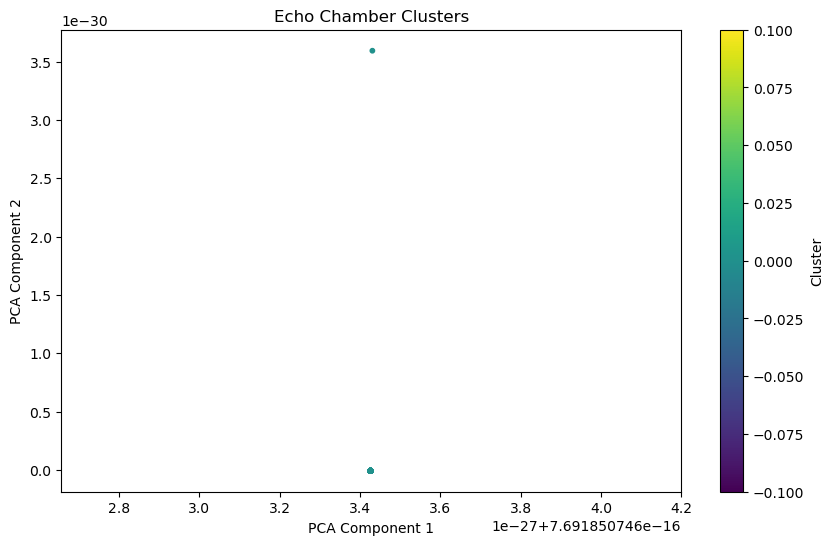

In [26]:
# Attempt: Visualize clusters (Dimensionality Reduction with PCA)
from sklearn.decomposition import PCA

def plot_clusters(data, texts, cluster_column):
    """
    Visualize the clustering results.

    Parameters:
    - data: DataFrame containing the data and cluster assignments.
    - texts: Original text data (used for dimensionality reduction).
    - cluster_column: Column name indicating cluster labels.
    """
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(texts)

    # Reduce dimensions for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X.toarray())

    plt.figure(figsize=(10, 6))
    plt.scatter(
        reduced_data[:, 0], 
        reduced_data[:, 1], 
        c=data[cluster_column], 
        cmap='viridis', 
        s=10
    )
    plt.colorbar(label="Cluster")
    plt.title("Echo Chamber Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# Plot the clusters
plot_clusters(data, data["clean_text"], "cluster")

In [ ]:
# Section 5: Algorithm Simulation


Algorithm Toxicity Table:
    platform  algorithm_toxicity
0    Bluesky                0.39
1   Facebook                0.42
2  Instagram                0.42
3   Mastodon                0.32
4    Twitter                0.32


/tmp/ipykernel_3391518/2770562696.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="platform", y="algorithm_toxicity", data=toxicity_table, palette="coolwarm")


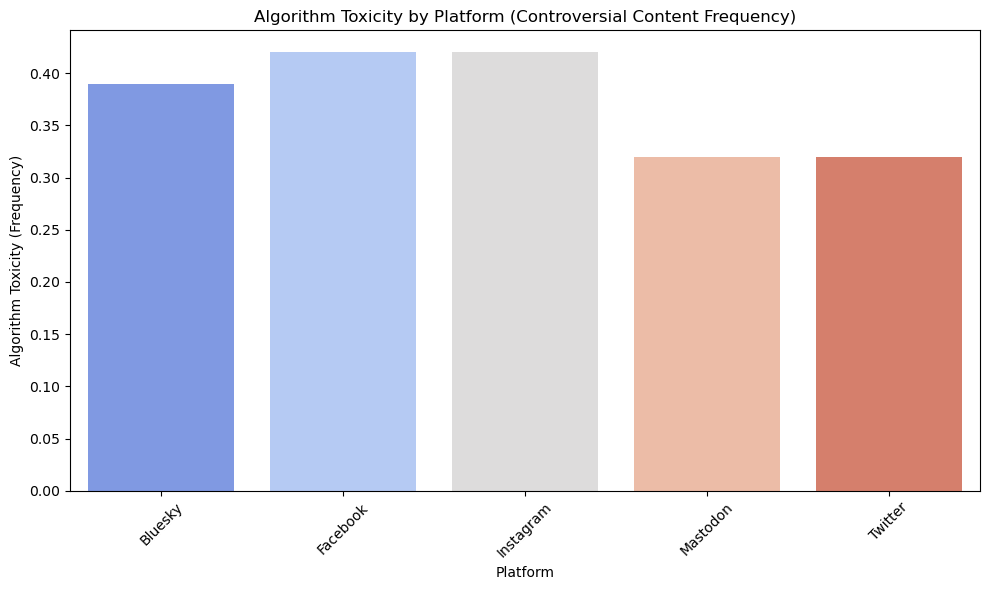

In [27]:
# Simulate content recommendation algorithms
# Detect algorithm toxicity (frequency of controversial content recommendations)
def calculate_algorithm_toxicity(data):
    toxicity = data.groupby("platform")["civility_score"].apply(
        lambda scores: sum(score < 2.5 for score in scores) / len(scores)
    )
    toxicity_table = pd.DataFrame({"platform": toxicity.index, "algorithm_toxicity": toxicity.values})
    return toxicity_table

# Create algorithm toxicity table
toxicity_table = calculate_algorithm_toxicity(data)
print("\nAlgorithm Toxicity Table:")
print(toxicity_table)

# Graph algorithm toxicity by platform
plt.figure(figsize=(10, 6))
sns.barplot(x="platform", y="algorithm_toxicity", data=toxicity_table, palette="coolwarm")
plt.title("Algorithm Toxicity by Platform (Controversial Content Frequency)")
plt.xlabel("Platform")
plt.ylabel("Algorithm Toxicity (Frequency)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Section 6: Database Integration

In [28]:
# Database setup
def setup_database():
    conn = sqlite3.connect("social_media_analysis.db")
    cursor = conn.cursor()
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS posts (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            platform TEXT,
            text TEXT,
            clean_text TEXT,
            created_at TEXT,
            user_id TEXT,
            civility_score REAL,
            intelligence_score REAL,
            cluster INTEGER
        )
    """)
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS survey (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            user_id TEXT,
            platform TEXT,
            civility_score REAL,
            usability_score REAL,
            echo_chamber_perception BOOLEAN,
            intelligence REAL
        )
    """)
    conn.commit()
    return conn


In [29]:
# Insert data into the database
def store_data(conn, dataframe, table_name):
    dataframe.to_sql(table_name, conn, if_exists="append", index=False)

# Setup database and insert generated data
conn = setup_database()
store_data(conn, data, "posts")
store_data(conn, survey_data, "survey")

# Verify the data insertion by querying the tables
cursor = conn.cursor()
cursor.execute("SELECT * FROM posts LIMIT 5")
print("Posts Table (First 5 Rows):")
for row in cursor.fetchall():
    print(row)

cursor.execute("SELECT * FROM survey LIMIT 5")
print("Survey Table (First 5 Rows):")
for row in cursor.fetchall():
    print(row)

# Close the connection
#conn.close()

Posts Table (First 5 Rows):
(1, 'Twitter', 'This is a sample post about topic one.', 'sample post topic one', '2024-11-11 19:29:25.526572', '5738', 1.33, 1.15, 0)
(2, 'Twitter', 'This is a sample post about topic three.', 'sample post topic three', '2024-11-25 00:29:25.526865', '1308', 2.35, 1.73, 0)
(3, 'Twitter', 'This is a sample post about topic three.', 'sample post topic three', '2024-11-20 03:29:25.526924', '2173', 3.83, 3.96, 0)
(4, 'Twitter', 'This is a sample post about topic two.', 'sample post topic two', '2024-11-30 13:29:25.526968', '4111', 2.73, 2.64, 0)
(5, 'Twitter', 'This is a sample post about topic four.', 'sample post topic four', '2024-11-23 03:29:25.527023', '8923', 1.35, 3.11, 0)
Survey Table (First 5 Rows):
(1, '8877', 'Mastodon', 4.815343109949831, 3.284141036852786, 1, 134.79040387970232)
(2, '6130', 'Twitter', 2.0913041603555094, 1.4517941692769862, 0, 111.65777935374892)
(3, '2415', 'Twitter', 4.252982467188087, 3.6370686076780667, 0, 108.25761885776677)
(4

In [ ]:
# Section 7: Queries/Database(sql) manipulations

In [30]:
# Query execution
def run_query(query):
    conn = sqlite3.connect("social_media_analysis.db")
    cursor = conn.cursor()
    cursor.execute(query)
    results = cursor.fetchall()
    conn.close()
    return results


In [31]:
print("Analyzing relationships with SQL queries...")

query = """
SELECT 
    p.platform AS platform,
    p.cluster AS cluster,
    COUNT(p.id) AS post_count
FROM posts p
GROUP BY p.platform, p.cluster
ORDER BY platform, cluster;
"""
result = pd.read_sql_query(query, conn)
print("\nCluster Distribution Across Platforms:")
print(result)


Analyzing relationships with SQL queries...

Cluster Distribution Across Platforms:
    platform  cluster  post_count
0    Bluesky        0         100
1   Facebook        0         100
2  Instagram        0         100
3   Mastodon        0         100
4    Twitter        0         100


In [32]:
query = """
SELECT 
    p.platform AS platform,
    AVG(p.civility_score) AS avg_civility,
    AVG(p.intelligence_score) AS avg_intelligence
FROM posts p
GROUP BY p.platform
ORDER BY avg_civility DESC;
"""
result = pd.read_sql_query(query, conn)
print("\nRelationships Between Civility and Intelligence Levels by Platform:")
print(result)



Relationships Between Civility and Intelligence Levels by Platform:
    platform  avg_civility  avg_intelligence
0    Bluesky        3.0623            2.8668
1    Twitter        3.0538            2.8305
2   Mastodon        3.0392            2.9469
3  Instagram        2.9631            2.9429
4   Facebook        2.9081            2.8909


In [33]:
query = """
SELECT 
    p.cluster AS cluster,
    AVG(p.civility_score) AS avg_civility,
    AVG(p.intelligence_score) AS avg_intelligence,
    COUNT(p.id) AS post_count
FROM posts p
GROUP BY p.cluster
ORDER BY avg_civility DESC, avg_intelligence DESC;
"""
result = pd.read_sql_query(query, conn)
print("\nCivility and Intelligence Levels by Clusters:")
print(result)



Civility and Intelligence Levels by Clusters:
   cluster  avg_civility  avg_intelligence  post_count
0        0        3.0053            2.8956         500


In [34]:
query = """
SELECT 
    p.id AS post_id,
    p.platform AS post_platform,
    p.text AS post_text,
    s.platform AS survey_platform,
    s.civility_score AS survey_civility,
    s.usability_score
FROM posts p
JOIN survey s ON p.user_id = s.user_id
LIMIT 10;
"""
result = pd.read_sql_query(query, conn)
print("\nPosts with Survey Data (First 10 Rows):")
print(result)



Posts with Survey Data (First 10 Rows):
   post_id post_platform                                post_text  \
0      111      Facebook   This is a sample post about topic two.   
1      161      Facebook   This is a sample post about topic two.   
2      182      Facebook  This is a sample post about topic five.   
3      316       Bluesky  This is a sample post about topic four.   

  survey_platform  survey_civility  usability_score  
0        Mastodon         1.487397         3.631279  
1         Twitter         2.408231         4.929874  
2         Bluesky         2.284428         4.174404  
3        Mastodon         1.364933         3.814905  


In [35]:
query = """
SELECT 
    p.platform AS post_platform,
    AVG(p.civility_score) AS avg_post_civility,
    AVG(s.civility_score) AS avg_survey_civility
FROM posts p
JOIN survey s ON p.user_id = s.user_id
GROUP BY p.platform;
"""
result = pd.read_sql_query(query, conn)
print("\nAverage Civility by Platform:")
print(result)



Average Civility by Platform:
  post_platform  avg_post_civility  avg_survey_civility
0       Bluesky           2.140000             1.364933
1      Facebook           2.976667             2.060018


In [36]:
query = """
SELECT 
    AVG(s.usability_score) AS avg_usability,
    AVG(p.civility_score) AS avg_post_civility
FROM survey s
JOIN posts p ON s.user_id = p.user_id
GROUP BY s.platform;
"""
result = pd.read_sql_query(query, conn)
print("\nUsability vs. Civility by Platform:")
print(result)



Usability vs. Civility by Platform:
   avg_usability  avg_post_civility
0       4.174404              3.490
1       3.723092              2.165
2       4.929874              3.250


In [37]:
query = """
SELECT 
    p.id AS post_id,
    p.civility_score AS post_civility,
    s.civility_score AS survey_civility,
    p.clean_text
FROM posts p
JOIN survey s ON p.user_id = s.user_id
WHERE p.civility_score < 2
ORDER BY p.civility_score ASC
LIMIT 10;
"""
result = pd.read_sql_query(query, conn)
print("\nComparison of Controversial Posts and Survey Civility (First 10 Rows):")
print(result)



Comparison of Controversial Posts and Survey Civility (First 10 Rows):
Empty DataFrame
Columns: [post_id, post_civility, survey_civility, clean_text]
Index: []


In [ ]:
# close database
conn.close()

In [ ]:
# Section 8: Visualization and Data Analysis

In [ ]:
# Civility Distribution
sns.histplot(data["civility_score"], bins=5, kde=False)
plt.title("Distribution of Civility Scores")
plt.xlabel("Civility Score")
plt.ylabel("Frequency")
plt.show()

# Intelligence vs Civility
sns.scatterplot(x="civility_score", y="intelligence_score", hue="cluster", data=data)
plt.title("Civility vs Intelligence by Cluster")
plt.xlabel("Civility Score")
plt.ylabel("Intelligence Score")
plt.legend(title="Cluster")
plt.show()


Cluster Distribution Across Platforms (Proportion):
    platform  cluster  count  proportion
0    Bluesky        0    100         1.0
1   Facebook        0    100         1.0
2  Instagram        0    100         1.0
3   Mastodon        0    100         1.0
4    Twitter        0    100         1.0


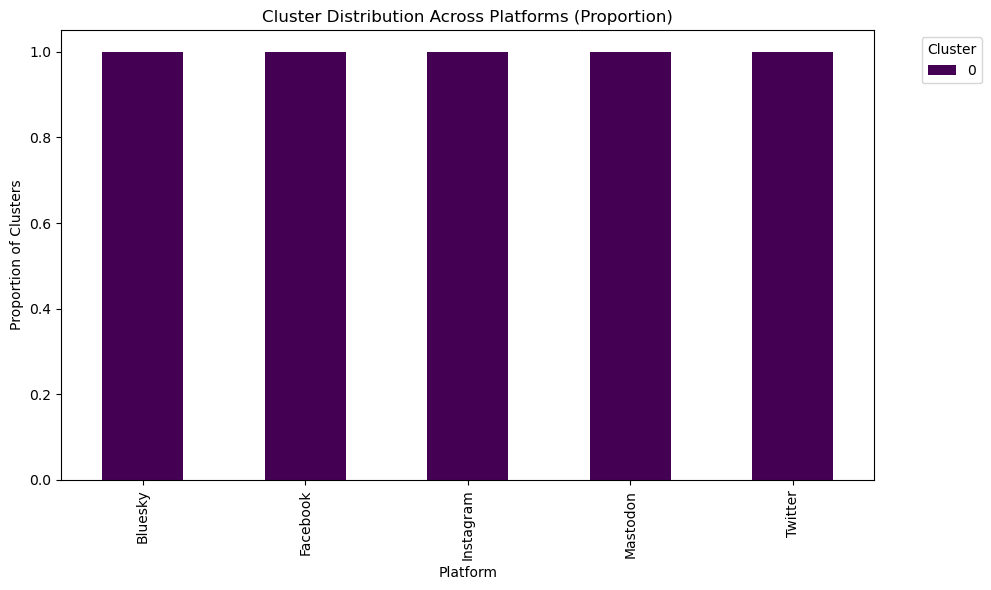

In [39]:
# Cluster Distribution Across Platforms
cluster_distribution = data.groupby(["platform", "cluster"]).size().reset_index(name="count")
total_counts = cluster_distribution.groupby("platform")["count"].transform("sum")
cluster_distribution["proportion"] = cluster_distribution["count"] / total_counts

print("\nCluster Distribution Across Platforms (Proportion):")
print(cluster_distribution)

# Visualization: Stacked Bar Chart for Cluster Distribution
platforms = cluster_distribution["platform"].unique()
clusters = cluster_distribution["cluster"].unique()
cluster_pivot = cluster_distribution.pivot(index="platform", columns="cluster", values="proportion").fillna(0)

cluster_pivot.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="viridis")
plt.title("Cluster Distribution Across Platforms (Proportion)")
plt.xlabel("Platform")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Intelligence Scores Across Platforms:
    platform  intelligence_score
0    Bluesky              2.8668
1   Facebook              2.8909
2  Instagram              2.9429
3   Mastodon              2.9469
4    Twitter              2.8305


/tmp/ipykernel_3391518/2720078814.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="platform", y="intelligence_score", data=intelligence, palette="coolwarm")


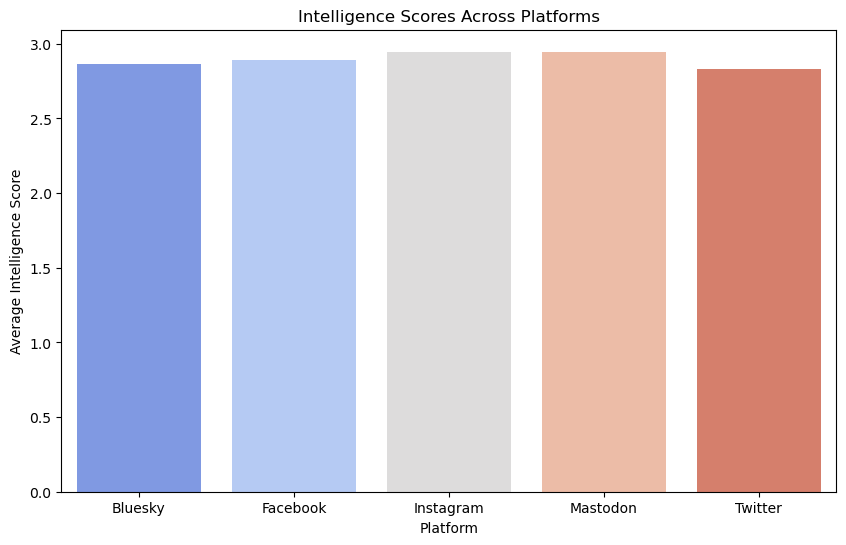

In [40]:
# Intelligence Scores Across Platforms
intelligence = data.groupby("platform")["intelligence_score"].mean().reset_index()
print("\nIntelligence Scores Across Platforms:")
print(intelligence)

# Visualization: Intelligence Scores
plt.figure(figsize=(10, 6))
sns.barplot(x="platform", y="intelligence_score", data=intelligence, palette="coolwarm")
plt.title("Intelligence Scores Across Platforms")
plt.xlabel("Platform")
plt.ylabel("Average Intelligence Score")
plt.show()

In [ ]:
import numpy as np
# Perception vs Reality (Civility and Intelligence)
# Aggregating actual scores from the posts
actual_scores = data.groupby("platform").agg({
    "civility_score": "mean",
    "intelligence_score": "mean"
}).reset_index()
actual_scores.columns = ["platform", "actual_civility_score", "actual_intelligence_score"]

# Aggregating survey scores
survey_scores = survey_data.groupby("platform").agg({
    "civility_score": "mean",
    "intelligence": "mean"
}).reset_index()
survey_scores.columns = ["platform", "perceived_civility_score", "perceived_intelligence_score"]

# Merge the two datasets for comparison
perception_vs_reality = pd.merge(actual_scores, survey_scores, on="platform")

print("\nPerception vs Reality of Civility and Intelligence Scores:")
print(perception_vs_reality)

# Visualization: Grouped Bar Chart for Perception vs Reality
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

x = np.arange(len(perception_vs_reality["platform"]))
width = 0.35  # Bar width

# Civility Comparison
ax[0].bar(x - width/2, perception_vs_reality["actual_civility_score"], width, label="Actual Civility Score", color="skyblue")
ax[0].bar(x + width/2, perception_vs_reality["perceived_civility_score"], width, label="Perceived Civility Score", color="orange")
ax[0].set_title("Perception vs Reality of Civility Scores Across Platforms")
ax[0].set_ylabel("Civility Score")
ax[0].set_xticks(x)
ax[0].set_xticklabels(perception_vs_reality["platform"])
ax[0].legend()

# Intelligence Comparison
ax[1].bar(x - width/2, perception_vs_reality["actual_intelligence_score"], width, label="Actual Intelligence Score", color="lightgreen")
ax[1].bar(x + width/2, perception_vs_reality["perceived_intelligence_score"], width, label="Perceived Intelligence Score", color="purple")
ax[1].set_title("Perception vs Reality of Intelligence Scores Across Platforms")
ax[1].set_ylabel("Intelligence Score")
ax[1].set_xticks(x)
ax[1].set_xticklabels(perception_vs_reality["platform"])
ax[1].legend()

plt.xlabel("Platform")
plt.tight_layout()
plt.show()


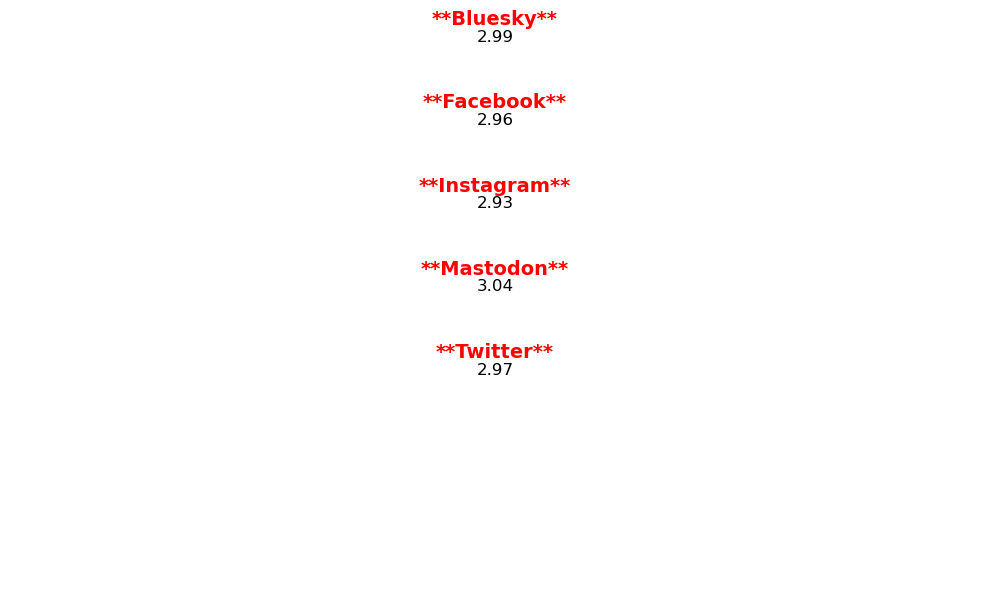

In [42]:
# Overall User Environment Score Calculation
# Calculate overall user environment score with adjusted weights
def calculate_overall_environment_weighted(data, survey_data):
    # Aggregate civility, intelligence, and cluster information
    post_metrics = data.groupby("platform").agg({
        "civility_score": "mean",
        "intelligence_score": "mean",
        "cluster": "nunique"
    }).reset_index()
    post_metrics.columns = ["platform", "avg_civility_score", "avg_intelligence_score", "num_clusters"]

    # Add usability from survey data
    survey_metrics = survey_data.groupby("platform")["usability_score"].mean().reset_index()
    survey_metrics.columns = ["platform", "avg_usability_score"]

    # Combine metrics
    overall_metrics = pd.merge(post_metrics, survey_metrics, on="platform")
    
    # Assign weights: civility and intelligence (0.4 each), usability and clusters (0.1 each), algorithm toxicity (0.2)
    civility_weight = 0.4
    intelligence_weight = 0.4
    usability_weight = 0.1
    cluster_weight = 0.1
    algorithm_weight = 0.2

    overall_metrics["overall_score"] = (
        (overall_metrics["avg_civility_score"] * civility_weight) +
        (overall_metrics["avg_intelligence_score"] * intelligence_weight) +
        (overall_metrics["avg_usability_score"] * usability_weight) -
        (toxicity_table["algorithm_toxicity"] * algorithm_weight) +
        ((5 - overall_metrics["num_clusters"]) * cluster_weight)  # Inverse cluster count for echo chamber score
    )
    return overall_metrics

# Calculate and display results
overall_metrics_weighted = calculate_overall_environment_weighted(data, survey_data)

# Graph overall user environment with emphasized app name and score
def plot_weighted_overall_environment(overall_metrics):
    plt.figure(figsize=(10, 6))
    plt.axis('off')  # Turn off axes for emphasis on the labels
    
    # Create a custom text-based display
    for i, row in enumerate(overall_metrics.itertuples()):
        app_text = f"**{row.platform}**"
        score_text = f"{row.overall_score:.2f}"
        plt.text(0.5, 1 - i * 0.15, app_text, fontsize=14, ha="center", color="red", weight="bold")
        plt.text(0.5, 1 - i * 0.15 - 0.03, score_text, fontsize=12, ha="center", color="black")
    
    plt.tight_layout()

# Call the function to plot
plot_weighted_overall_environment(overall_metrics_weighted)

In [ ]:
# Section 9: Machine Learning: Relationships and Analysis

In [43]:
# Civility and Intelligence
def analyze_relationships(data):
    # Use Linear Regression to analyze relationships.
    # Civility and Intelligence Relationship
    X = data[["civility_score"]]
    y = data["intelligence_score"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")
    return model

relationship_model = analyze_relationships(data)


Mean Squared Error: 1.40
R-squared: -0.02


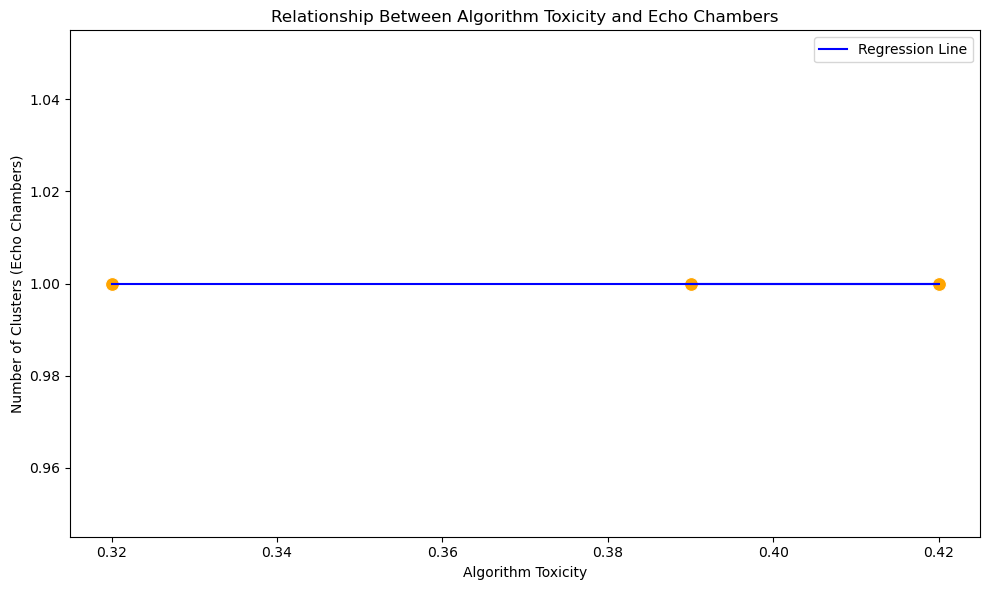


Combined Data (Algorithm Toxicity vs. Echo Chambers):
    platform  algorithm_toxicity  num_clusters
0    Bluesky                0.39             1
1   Facebook                0.42             1
2  Instagram                0.42             1
3   Mastodon                0.32             1
4    Twitter                0.32             1

Linear Regression Coefficient: -0.00, Intercept: 1.00


In [44]:
# Algorithms and Echo chambers
# Use linear regression to analyze the relationship between algorithm toxicity and echo chambers
from sklearn.linear_model import LinearRegression

def analyze_toxicity_vs_clusters(toxicity_table, data):
    cluster_data = data.groupby("platform")["cluster"].nunique().reset_index()
    cluster_data.columns = ["platform", "num_clusters"]
    combined_data = pd.merge(toxicity_table, cluster_data, on="platform")

    # Regression
    X = combined_data["algorithm_toxicity"].values.reshape(-1, 1)
    y = combined_data["num_clusters"].values
    model = LinearRegression().fit(X, y)

    # Graph the relationship
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="algorithm_toxicity", y="num_clusters", data=combined_data, s=100, color="orange")
    plt.plot(combined_data["algorithm_toxicity"], model.predict(X), color="blue", label="Regression Line")
    plt.title("Relationship Between Algorithm Toxicity and Echo Chambers")
    plt.xlabel("Algorithm Toxicity")
    plt.ylabel("Number of Clusters (Echo Chambers)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return combined_data, model.coef_, model.intercept_

toxicity_vs_clusters_data, coef, intercept = analyze_toxicity_vs_clusters(toxicity_table, data)
print("\nCombined Data (Algorithm Toxicity vs. Echo Chambers):")
print(toxicity_vs_clusters_data)
print(f"\nLinear Regression Coefficient: {coef[0]:.2f}, Intercept: {intercept:.2f}")


In [45]:
# Summary
print("\nFinal Data Sample:")
print(data.head())
print(survey_data.head())
print("\nOverall User Environment Scores:")
print(overall_metrics)


Final Data Sample:
  platform                                      text  \
0  Twitter    This is a sample post about topic one.   
1  Twitter  This is a sample post about topic three.   
2  Twitter  This is a sample post about topic three.   
3  Twitter    This is a sample post about topic two.   
4  Twitter   This is a sample post about topic four.   

                  created_at  user_id               clean_text  \
0 2024-11-11 19:29:25.526572     5738    sample post topic one   
1 2024-11-25 00:29:25.526865     1308  sample post topic three   
2 2024-11-20 03:29:25.526924     2173  sample post topic three   
3 2024-11-30 13:29:25.526968     4111    sample post topic two   
4 2024-11-23 03:29:25.527023     8923   sample post topic four   

   civility_score  intelligence_score  cluster  
0            1.33                1.15        0  
1            2.35                1.73        0  
2            3.83                3.96        0  
3            2.73                2.64        0  
4

NameError: name 'overall_metrics' is not defined